# 3D Convolutional Neural Network for Tomographic Alignment

## Expanding the Network: ResNet and Engineering the Data Again

Since based on previous analysis it is likely that the network was too small to properly identify the features necessary for alignment, the next logical step is to expand the network. Making deeper neural networks usually results in diminishing returns, but residual neural networks have proven to successfully allow for deeper neural networks. Now this model structure will be used in order to find some form of convergence.

While it seems like the ResNet will increase the performance of the model on larger training sets, testing convergence is still a major problem. Now the input data will be modified to find the difference between each projection which should help the network better isolate the pattern we want it to find. This will hopefully allow for better understanding of the specific alignment problem by the neural network.

In [1]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))
!pwd

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True
/home/liam/Projects/Tomographic Alignment


In [3]:
# The resulting function that can be used for modifying the data
def data_mean_difference(data):
    
    # Create copy of dataset for projections to be modified, also initializes array for mean projections
    projections = data[:, 0].copy()
    mean_projections = np.zeros((projections.shape[0]), dtype = object)
    
    # Iterate through each projection stack
    for i in range (projections.shape[0]):

        # Get rid of extra dimensions for neural networks and create a mean projection
        projections[i] = np.squeeze(projections[i])
        mean_projections[i] = np.mean(projections[i], axis = 0)

        # Iterate through every projection in stack
        for j in range (projections[0].shape[0]):

            # Change current projection to difference between current projection and mean projection
            projections[i][j] = projections[i][j] - mean_projections[i]
            
        # Expand dimensions to original form for neural networks
        projections[i] = np.expand_dims(projections[i], axis = 0)
        projections[i] = np.expand_dims(projections[i], axis = 0)

    # Create data difference array
    data_diff = data.copy()

    # Replace all data with the new difference projections
    for i in range (data.shape[0]):

        data_diff[i][0] = projections[i]
        
    return data_diff

In [4]:
def data_difference(data):

    data_diff = np.zeros((data.shape), dtype = object)
    projections = []

    for i in range (entries):
        projections.append(np.squeeze(data[:, 0][i]))

    projections = np.asarray(projections)

    differences = np.zeros((250, projections[0].shape[0] - 1), dtype = object)

    for i in range (entries):

        for j in range (projections[0].shape[0] - 1):

            differences[i, j] = (projections[i][j + 1] - projections[i][j])

    for i in range (data_diff.shape[0]):

        data_diff[i][0] = np.zeros((differences.shape[1], differences[0, 0].shape[0], differences[0,0].shape[1]))
        data_diff[i][1] = data[i][1]

        for j in range (projections[0].shape[0] - 1):

            data_diff[i][0][j] = differences[i, j]

        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)
        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)

    return data_diff

In [5]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 25
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)


# data = data_mean_difference(data)
data = data_difference(data)

In [6]:
# Checking shape of training and testing splits
trainset, testset = np.split(data, [int(entries * 4 / 5)])
print("Shape of Training Dataset: {}".format(trainset.shape))
print("Shape of Testing Dataset: {}".format(testset.shape))

Shape of Training Dataset: (20, 2)
Shape of Testing Dataset: (5, 2)


In [7]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# Get inplanes for resnet
def get_inplanes():
    return [64, 128, 256, 512]


# Preset for a 3x3x3 kernel convolution
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


# Preset for a 1x1x1 kernel convolution
def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

# Basic block for resnet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
# Bottleneck block for resnet
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    

# Resnet structure
class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=1,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=360):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    # make layer helper function
    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Generates form of resnet
def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

In [8]:
model = generate_model(50)
summary(model, (1, 1, 180, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 360]                  --
├─Conv3d: 1-1                            [1, 64, 180, 64, 92]      21,952
├─BatchNorm3d: 1-2                       [1, 64, 180, 64, 92]      128
├─ReLU: 1-3                              [1, 64, 180, 64, 92]      --
├─MaxPool3d: 1-4                         [1, 64, 90, 32, 46]       --
├─Sequential: 1-5                        [1, 256, 90, 32, 46]      --
│    └─Bottleneck: 2-1                   [1, 256, 90, 32, 46]      --
│    │    └─Conv3d: 3-1                  [1, 64, 90, 32, 46]       4,096
│    │    └─BatchNorm3d: 3-2             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-3                    [1, 64, 90, 32, 46]       --
│    │    └─Conv3d: 3-4                  [1, 64, 90, 32, 46]       110,592
│    │    └─BatchNorm3d: 3-5             [1, 64, 90, 32, 46]       128
│    │    └─ReLU: 3-6                    [1, 64, 90, 32, 46]       --


In [14]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = generate_model(50)
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 5e-2, momentum=0.9, weight_decay = 0)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 500

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device).float()), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device).float()), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Validation Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 12.569259285926819 
Epoch: 0   Validation Loss: 8.960946464538575 
Epoch: 1   Training Loss: 9.144684958457947 
Epoch: 1   Validation Loss: 11.09910831451416 
Epoch: 2   Training Loss: 9.174124169349671 
Epoch: 2   Validation Loss: 8.002226161956788 
Epoch: 3   Training Loss: 8.506996178627015 
Epoch: 3   Validation Loss: 8.024258136749268 
Epoch: 4   Training Loss: 8.348653173446655 
Epoch: 4   Validation Loss: 8.162216758728027 
Epoch: 5   Training Loss: 8.322318530082702 
Epoch: 5   Validation Loss: 8.21976203918457 
Epoch: 6   Training Loss: 8.319579100608825 
Epoch: 6   Validation Loss: 8.215788269042969 
Epoch: 7   Training Loss: 8.307487392425537 
Epoch: 7   Validation Loss: 8.21584186553955 
Epoch: 8   Training Loss: 8.299998760223389 
Epoch: 8   Validation Loss: 8.220346450805664 
Epoch: 9   Training Loss: 8.29520661830902 
Epoch: 9   Validation Loss: 8.22338171005249 
Epoch: 10   Training Loss: 8.291370749473572 
Epoch: 10   Validation

Epoch: 88   Training Loss: 8.262976837158202 
Epoch: 88   Validation Loss: 8.234258079528809 
Epoch: 89   Training Loss: 8.26187481880188 
Epoch: 89   Validation Loss: 8.235258674621582 
Epoch: 90   Training Loss: 8.260921311378478 
Epoch: 90   Validation Loss: 8.235381984710694 
Epoch: 91   Training Loss: 8.260008430480957 
Epoch: 91   Validation Loss: 8.236366653442383 
Epoch: 92   Training Loss: 8.259218955039978 
Epoch: 92   Validation Loss: 8.237056350708007 
Epoch: 93   Training Loss: 8.258497333526611 
Epoch: 93   Validation Loss: 8.237780284881591 
Epoch: 94   Training Loss: 8.257835793495179 
Epoch: 94   Validation Loss: 8.23843011856079 
Epoch: 95   Training Loss: 8.257223463058471 
Epoch: 95   Validation Loss: 8.23863344192505 
Epoch: 96   Training Loss: 8.256591057777404 
Epoch: 96   Validation Loss: 8.23928918838501 
Epoch: 97   Training Loss: 8.256066584587098 
Epoch: 97   Validation Loss: 8.239816761016845 
Epoch: 98   Training Loss: 8.255568671226502 
Epoch: 98   Valida

Epoch: 174   Training Loss: 8.24122200012207 
Epoch: 174   Validation Loss: 8.249147605895995 
Epoch: 175   Training Loss: 8.241117453575134 
Epoch: 175   Validation Loss: 8.24915018081665 
Epoch: 176   Training Loss: 8.241029214859008 
Epoch: 176   Validation Loss: 8.249224662780762 
Epoch: 177   Training Loss: 8.240936422348023 
Epoch: 177   Validation Loss: 8.249260139465331 
Epoch: 178   Training Loss: 8.240850639343261 
Epoch: 178   Validation Loss: 8.249312114715575 
Epoch: 179   Training Loss: 8.240770077705383 
Epoch: 179   Validation Loss: 8.249272060394286 
Epoch: 180   Training Loss: 8.240680241584778 
Epoch: 180   Validation Loss: 8.249236583709717 
Epoch: 181   Training Loss: 8.240581250190735 
Epoch: 181   Validation Loss: 8.249327564239502 
Epoch: 182   Training Loss: 8.240504598617553 
Epoch: 182   Validation Loss: 8.249422073364258 
Epoch: 183   Training Loss: 8.240433287620544 
Epoch: 183   Validation Loss: 8.249446678161622 
Epoch: 184   Training Loss: 8.240350985527

Epoch: 260   Training Loss: 8.172235941886902 
Epoch: 260   Validation Loss: 8.268188190460204 
Epoch: 261   Training Loss: 8.190795016288757 
Epoch: 261   Validation Loss: 8.244248962402343 
Epoch: 262   Training Loss: 8.250867915153503 
Epoch: 262   Validation Loss: 8.244610023498534 
Epoch: 263   Training Loss: 8.24248435497284 
Epoch: 263   Validation Loss: 8.246143627166749 
Epoch: 264   Training Loss: 8.24123773574829 
Epoch: 264   Validation Loss: 8.247049903869629 
Epoch: 265   Training Loss: 8.240451407432555 
Epoch: 265   Validation Loss: 8.247718620300294 
Epoch: 266   Training Loss: 8.239970445632935 
Epoch: 266   Validation Loss: 8.248249626159668 
Epoch: 267   Training Loss: 8.239641118049622 
Epoch: 267   Validation Loss: 8.248834896087647 
Epoch: 268   Training Loss: 8.23938274383545 
Epoch: 268   Validation Loss: 8.249234008789063 
Epoch: 269   Training Loss: 8.239156579971313 
Epoch: 269   Validation Loss: 8.249497222900391 
Epoch: 270   Training Loss: 8.2389758586883

Epoch: 346   Training Loss: 7.522854995727539 
Epoch: 346   Validation Loss: 8.386234188079834 
Epoch: 347   Training Loss: 7.492452907562256 
Epoch: 347   Validation Loss: 8.4160888671875 
Epoch: 348   Training Loss: 7.4549973726272585 
Epoch: 348   Validation Loss: 8.453057861328125 
Epoch: 349   Training Loss: 7.45195574760437 
Epoch: 349   Validation Loss: 8.477999591827393 
Epoch: 350   Training Loss: 7.397576546669006 
Epoch: 350   Validation Loss: 8.642270278930663 
Epoch: 351   Training Loss: 7.537117981910706 
Epoch: 351   Validation Loss: 8.457696628570556 
Epoch: 352   Training Loss: 7.88538556098938 
Epoch: 352   Validation Loss: 8.347609615325927 
Epoch: 353   Training Loss: 7.687903523445129 
Epoch: 353   Validation Loss: 8.59263505935669 
Epoch: 354   Training Loss: 7.82047164440155 
Epoch: 354   Validation Loss: 8.385050678253174 
Epoch: 355   Training Loss: 7.540089440345764 
Epoch: 355   Validation Loss: 8.570156478881836 
Epoch: 356   Training Loss: 7.430235171318054

Epoch: 432   Training Loss: 5.1696601316332815 
Epoch: 432   Validation Loss: 9.4443528175354 
Epoch: 433   Training Loss: 5.047721242904663 
Epoch: 433   Validation Loss: 9.414839744567871 
Epoch: 434   Training Loss: 4.916485255956649 
Epoch: 434   Validation Loss: 9.726765632629395 
Epoch: 435   Training Loss: 4.719050472974777 
Epoch: 435   Validation Loss: 9.691676425933839 
Epoch: 436   Training Loss: 4.582377475500107 
Epoch: 436   Validation Loss: 9.58796796798706 
Epoch: 437   Training Loss: 4.3469049200415615 
Epoch: 437   Validation Loss: 9.624526023864746 
Epoch: 438   Training Loss: 4.1928060978651045 
Epoch: 438   Validation Loss: 9.66693344116211 
Epoch: 439   Training Loss: 4.086426547169685 
Epoch: 439   Validation Loss: 9.7801983833313 
Epoch: 440   Training Loss: 4.018745368719101 
Epoch: 440   Validation Loss: 9.994874572753906 
Epoch: 441   Training Loss: 4.112797950208187 
Epoch: 441   Validation Loss: 9.592630386352539 
Epoch: 442   Training Loss: 4.1681909054517

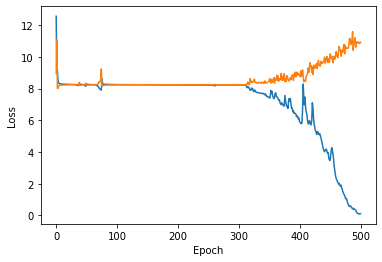

In [15]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

After inputting the stack of projection differences into the neural network it still shows convergence with a small number of samples, now to test for a larger dataset.